# PDBbind dataset

> 这里为了加快实验进展，直接使用PDBbind提供的pocket和ligand数据，然后将其反序列化得到其序列表示，最后融合到PocketDTA模型中，得到预测结果。看来是行不通的，因为使用3D数据构建Molecule和Protein有报错无法生成的问题。

##  1 Read raw data from the PDBbind

> The raw data can be downloaded from [PDBbind-CN Repository]( http://www.pdbbind.org.cn/download.php).

As each pdb name file contains 4 file:
- 1a0q_ligand.mol2
- 1a0q_ligand.sdf  // both mol2 and sdf are for mol structure
- 1a0q_pocket.pdb   // for pocket structure
- 1a0q_protein.pdb   // for protein structure

### 1.1 PDB id extraction [Done]

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm  

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_id = pd.read_csv(f'{pre}/PDBbind_index/index/INDEX_general_PL_name.2020', sep="  ", comment='#', header=None, names=['pdb', 'year', 'uid', 'name', 'others'], engine='python')
pdbbind_id

pdb  year     uid                                               name  \
0      6mu1  2018  P29994       INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
1      3t8s  2011  P29994       INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
2      1n4k  2002  P11881       INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
3      5urm  2017  O75643  U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
4      5urj  2017  O75643  U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
...     ...   ...     ...                                                ...   
19438  1swi  1996  P03069                                             GCN4P1   
19439  2lk1  2011  P52756                              RNA-BINDING PROTEIN 5   
19440  6eiz  2018  ------                                            CC-HEX2   
19441  2ly0  2013  Q6XT21                            MEMBRANE ION CHANNEL M2   
19442  2lyw  2012  P30989                        NEUROTENSIN RECEPTOR TYPE 1   

      others  
0       None  
1       None  
2       None  
3       None  
4       None  
...      ...  
19438   None  
19439   None  
19440   None  
19441   None  
19442   None  

[19443 rows x 5 columns]

In [4]:
pdbbind_id.shape  # all 68 drugs and 442 proteins make the matrix

(19443, 5)

In [5]:
pdbbind_id = pdbbind_id[['pdb','uid']] # contain only the pdb name and uid
pdbbind_id

pdb     uid
0      6mu1  P29994
1      3t8s  P29994
2      1n4k  P11881
3      5urm  O75643
4      5urj  O75643
...     ...     ...
19438  1swi  P03069
19439  2lk1  P52756
19440  6eiz  ------
19441  2ly0  Q6XT21
19442  2lyw  P30989

[19443 rows x 2 columns]

In [6]:
pdbbind_id['pdb']

0        6mu1
1        3t8s
2        1n4k
3        5urm
4        5urj
         ... 
19438    1swi
19439    2lk1
19440    6eiz
19441    2ly0
19442    2lyw
Name: pdb, Length: 19443, dtype: object

In [7]:
pdbbind_id['pdb'].str.upper()

0        6MU1
1        3T8S
2        1N4K
3        5URM
4        5URJ
         ... 
19438    1SWI
19439    2LK1
19440    6EIZ
19441    2LY0
19442    2LYW
Name: pdb, Length: 19443, dtype: object

In [8]:
pdbbind_id

pdb     uid
0      6mu1  P29994
1      3t8s  P29994
2      1n4k  P11881
3      5urm  O75643
4      5urj  O75643
...     ...     ...
19438  1swi  P03069
19439  2lk1  P52756
19440  6eiz  ------
19441  2ly0  Q6XT21
19442  2lyw  P30989

[19443 rows x 2 columns]

In [9]:
pdbbind_id['pdb'] = pdbbind_id['pdb'].str.upper()
pdbbind_id

/tmp/ipykernel_37789/3985334227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdbbind_id['pdb'] = pdbbind_id['pdb'].str.upper()


pdb     uid
0      6MU1  P29994
1      3T8S  P29994
2      1N4K  P11881
3      5URM  O75643
4      5URJ  O75643
...     ...     ...
19438  1SWI  P03069
19439  2LK1  P52756
19440  6EIZ  ------
19441  2LY0  Q6XT21
19442  2LYW  P30989

[19443 rows x 2 columns]

In [10]:
len(pdbbind_id["uid"].unique())  # '------' for unknown

3890

In [11]:
pdb_uid_dict = dict(zip(pdbbind_id['pdb'], pdbbind_id['uid'],))
pdb_uid_dict

{'6MU1': 'P29994',
 '3T8S': 'P29994',
 '1N4K': 'P11881',
 '5URM': 'O75643',
 '5URJ': 'O75643',
 '5URK': 'O75643',
 '3EQL': 'Q9Z9H6',
 '1ZYR': 'Q5SHR6',
 '3DXJ': 'Q5SHR6',
 '4WZ6': 'P13569',
 '6O2P': 'P13569',
 '5UAH': 'P0A7Z4',
 '5UAL': 'P0A7Z4',
 '4ZH4': 'P0A7Z4',
 '4ZH3': 'P0A7Z4',
 '4ZH2': 'P0A7Z4',
 '4XSX': 'A7ZSI4',
 '4XSY': 'A7ZSI4',
 '4XSZ': 'A7ZSI4',
 '4MEX': 'P0A7Z4',
 '4KN4': 'P0A7Z4',
 '4KN7': 'P0A7Z4',
 '4KMU': 'P0A7Z4',
 '5UAC': 'P0A7Z4',
 '5SWG': 'P42336',
 '5SXK': 'P42336',
 '4WAF': 'P42336',
 '5XGH': 'P42336',
 '6GVG': 'P42336',
 '6GVH': 'P42336',
 '6OCO': 'O00329',
 '5UK8': 'P42336',
 '5ITD': 'P42336',
 '5UL1': 'P42336',
 '6GVI': 'P42336',
 '6PYS': 'P42336',
 '5UKJ': 'P42336',
 '6GVF': 'P42336',
 '4L23': 'P42336',
 '3HHM': 'P42336',
 '6OAC': 'P42336',
 '6PYU': 'O00329',
 '4YKN': 'P27986',
 '3ZIM': 'P42336',
 '4JPS': 'P42336',
 '5DXU': 'O00329',
 '5VLR': 'O00329',
 '5UBT': 'O00329',
 '4TV3': 'P42336',
 '6PYR': 'O00329',
 '5DXH': 'P42336',
 '6G6W': 'O00329',
 '5DXT': 'P4

In [12]:
len(pdb_uid_dict)

19443

In [13]:
pdbbind_id.to_csv(f'{pre}/pdbbind_id.csv', index=None)

###  1.2 Protein fasta file download [Done]

TODO 目前发现如果直接使用pocket会有很多蛋白质无法识别，这里想着能不能退而求次，通过PocketDTA里同样的方法，从序列开始入手构成数据集数据
- pdb name -> protein sequence by  **RCSB PDB dataset**

> sequence url: https://www.rcsb.org/fasta/entry/6NZG

In [14]:
prefix = 'https://www.rcsb.org/fasta/entry/'
suffix = '.fasta'

In [15]:
import os
from torchdrug import utils
from tqdm import tqdm
urls = []
path = '../../../data/dta-datasets/PDBbind/PDBbind_sequence/'
for pdb in tqdm(pdbbind_id.pdb):
    url = prefix + pdb
    pdb_name = pdb + "_proteinSeq" + suffix
    seq_file = os.path.join(path, pdb_name)
    if os.path.exists(seq_file):
        print("==================== Using the old file: ", seq_file, "====================")
    else:
        if url not in urls:
            urls.append(url)
            try:
                utils.download(url=url, path=path, save_file=pdb_name)
            except:
                print(f'This url: {url} can not be downloaded')

100%|██████████| 19443/19443 [00:00<00:00, 109409.58it/s]

==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/6MU1_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/3T8S_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/1N4K_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/5URM_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/5URJ_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/5URK_proteinSeq.fasta ====================
==================== Using the old file:  ../../../data/dta-datasets/PDBbind/PDBbind_sequence/3EQL_proteinSeq.fasta ====================
==================== Using the old file: 

can not be downloaded pdb are these 4:
- 1QON  replaced by 6XYU
- 4JDF replaced by 7OYZ
- 5AB1 replaced by 6YHW
- 4POX replaced by 5OVZ

### 1.3 affinity file read [Done]

In [1]:
# form tankbind/utils
import pandas as pd
def read_pdbbind_data(fileName):
    with open(fileName) as f:
        a = f.readlines()
    info = []
    for line in a:
        if line[0] == '#':
            continue
        lines, ligand = line.split('//')
        pdb, resolution, year, affinity, raw = lines.strip().split('  ')
        ligand = ligand.strip().split('(')[1].split(')')[0]
        # print(lines, ligand)
        info.append([pdb, resolution, year, affinity, raw, ligand])
    info = pd.DataFrame(info, columns=['pdb', 'resolution', 'year', 'affinity', 'raw', 'ligand'])
    info.year = info.year.astype(int)
    info.affinity = info.affinity.astype(float)
    return info

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
data = read_pdbbind_data(f'{pre}/PDBbind_index/index/INDEX_general_PL_data.2020')
data

pdb resolution  year  affinity         raw   ligand
0      3zzf       2.20  2012      0.40    Ki=400mM      NLG
1      3gww       2.46  2009      0.45  IC50=355mM      SFX
2      1w8l       1.80  2004      0.49    Ki=320mM      1P3
3      3fqa       2.35  2009      0.49  IC50=320mM  GAB&PMP
4      1zsb       2.00  1996      0.60    Kd=250mM      AZM
...     ...        ...   ...       ...         ...      ...
19438  7cpa       2.00  1994     13.96     Ki=11fM      FVF
19439  2xuf       2.55  2010     14.39    Kd=4.1fM      TZ4
19440  1avd       2.70  1994     15.00      Kd=1fM      BTN
19441  2xui       2.60  2010     15.00    Kd=1.0fM      TZ5
19442  2avi       3.00  1993     15.22    Kd=0.6fM      BTN

[19443 rows x 6 columns]

In [4]:
data['pdb'] = data['pdb'].str.upper()
data

pdb resolution  year  affinity         raw   ligand
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM
...     ...        ...   ...       ...         ...      ...
19438  7CPA       2.00  1994     13.96     Ki=11fM      FVF
19439  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4
19440  1AVD       2.70  1994     15.00      Kd=1fM      BTN
19441  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5
19442  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN

[19443 rows x 6 columns]

In [5]:
data.to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

### 1.4 fasta file extraction [Done]

As many pdb contain several aa chains, but we only need one for DTA？
用不用提取肽链，还是整个输入？由于之前的方法就是整个输入的，这里就不提取具体相互作用的肽链了，因此目前的策略就是将pdb里面所有的肽链拼接到一起，作为其序列特征构成数据集的一列，在P2rank里输入已有的Pdb得到预测结果。

In [1]:
import os
import fastaparser
import pandas as pd
from tqdm import tqdm

In [2]:
seq_path = '../../../data/dta-datasets/PDBbind/PDBbind_sequence/'
pdb_id_csv = '../../../data/dta-datasets/PDBbind/pdbbind_id.csv'
suffix = '.fasta'

In [3]:
pdbbind_id = pd.read_csv(pdb_id_csv)
pdbbind_id

pdb     uid
0      6MU1  P29994
1      3T8S  P29994
2      1N4K  P11881
3      5URM  O75643
4      5URJ  O75643
...     ...     ...
19438  1SWI  P03069
19439  2LK1  P52756
19440  6EIZ  ------
19441  2LY0  Q6XT21
19442  2LYW  P30989

[19443 rows x 2 columns]

In [4]:
pdbbind_id.insert(pdbbind_id.shape[1], 'sequence', '')

In [5]:
pdbbind_id

pdb     uid sequence
0      6MU1  P29994         
1      3T8S  P29994         
2      1N4K  P11881         
3      5URM  O75643         
4      5URJ  O75643         
...     ...     ...      ...
19438  1SWI  P03069         
19439  2LK1  P52756         
19440  6EIZ  ------         
19441  2LY0  Q6XT21         
19442  2LYW  P30989         

[19443 rows x 3 columns]

In [6]:
pdbbind_id.insert(pdbbind_id.shape[1], 'chain_description', '')

In [7]:
pdbbind_id

pdb     uid sequence chain_description
0      6MU1  P29994                           
1      3T8S  P29994                           
2      1N4K  P11881                           
3      5URM  O75643                           
4      5URJ  O75643                           
...     ...     ...      ...               ...
19438  1SWI  P03069                           
19439  2LK1  P52756                           
19440  6EIZ  ------                           
19441  2LY0  Q6XT21                           
19442  2LYW  P30989                           

[19443 rows x 4 columns]

In [8]:
for i, line in tqdm(pdbbind_id.iterrows(), total=pdbbind_id.shape[0]):
    seq_list = '' # 拼接用逗号,
    des_list = [] # 拼记录每个chain的长度
    pdb_name = line['pdb'].upper() + "_proteinSeq" + suffix
    seq_file = os.path.join(seq_path, pdb_name)
    with open(seq_file, 'r') as fasta:
        reader = fastaparser.Reader(fasta_file=fasta, sequences_type='aminoacid', parse_method='quick')
        for sequence in reader:
            seq_list += sequence.sequence
            count = len(sequence.sequence)
            des_list .append(count)
    line['sequence'] = seq_list
    line['chain_description'] = des_list

100%|██████████| 19443/19443 [00:02<00:00, 6714.90it/s]


In [9]:
pdbbind_id

pdb     uid                                           sequence  \
0      6MU1  P29994  MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDL...   
1      3T8S  P29994  GSEFSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNN...   
2      1N4K  P11881  MKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGR...   
3      5URM  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
4      5URJ  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
...     ...     ...                                                ...   
19438  1SWI  P03069                  RMKQLEDKVEELLSKAYHLENEVARLKKLVGER   
19439  2LK1  P52756                   XKFEDWLCNKCCLNNFRKRLKCFRCGADKFDX   
19440  6EIZ  ------                   XGEIAKSLKEIAKSLKEIAWSLKEIAKSLKGX   
19441  2LY0  Q6XT21                    SNDSSDPLVVAANIIGILHLILWILDRLFFK   
19442  2LYW  P30989              VRRLMFSYISDEQWTPFLYDFYHYQLYENKPRRPYIL   

      chain_description  
0                [2739]  
1                 [585]  
2                 [381]  
3                [1738]  
4                [1738]  
...                 ...  
19438              [33]  
19439              [32]  
19440              [32]  
19441              [31]  
19442          [24, 13]  

[19443 rows x 4 columns]

In [10]:
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'

In [11]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM
...     ...        ...   ...       ...         ...      ...
19438  7CPA       2.00  1994     13.96     Ki=11fM      FVF
19439  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4
19440  1AVD       2.70  1994     15.00      Kd=1fM      BTN
19441  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5
19442  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN

[19443 rows x 6 columns]

In [12]:
pdbbind_affinities = pdbbind_affinities.merge(pdbbind_id, on=['pdb'])
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19438  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19439  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19440  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19441  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19442  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]  
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]  
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]  
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]  
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]  
...                                                  ...               ...  
19438  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]  
19439  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]  
19440  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  
19441  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]  
19442  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  

[19443 rows x 9 columns]

In [13]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

### 1.5 unique protein file [Done]

In [14]:
len(pdbbind_id['sequence'].unique())  # unique protein numbers

9034

In [15]:
pdbbind_id.drop_duplicates(subset=['sequence'], keep='first', inplace=True)

In [16]:
pdbbind_id

pdb     uid                                           sequence  \
0      6MU1  P29994  MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDL...   
1      3T8S  P29994  GSEFSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNN...   
2      1N4K  P11881  MKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGR...   
3      5URM  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
6      3EQL  Q9Z9H6  MLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLS...   
...     ...     ...                                                ...   
19438  1SWI  P03069                  RMKQLEDKVEELLSKAYHLENEVARLKKLVGER   
19439  2LK1  P52756                   XKFEDWLCNKCCLNNFRKRLKCFRCGADKFDX   
19440  6EIZ  ------                   XGEIAKSLKEIAKSLKEIAWSLKEIAKSLKGX   
19441  2LY0  Q6XT21                    SNDSSDPLVVAANIIGILHLILWILDRLFFK   
19442  2LYW  P30989              VRRLMFSYISDEQWTPFLYDFYHYQLYENKPRRPYIL   

                chain_description  
0                          [2739]  
1                           [585]  
2                           [381]  
3                          [1738]  
6      [315, 1119, 1524, 99, 423]  
...                           ...  
19438                        [33]  
19439                        [32]  
19440                        [32]  
19441                        [31]  
19442                    [24, 13]  

[9034 rows x 4 columns]

In [17]:
protein_csv = '../../../data/dta-datasets/PDBbind/pdbbind_proteins.csv'

In [18]:
pdbbind_id.to_csv(protein_csv, index=None)

### 1.4 Pocket pkl building [Done]

In [1]:
import warnings
from torchdrug import data
from rdkit import Chem
import pandas as pd
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"
protein_csv = '../../../data/dta-datasets/PDBbind/pdbbind_proteins.csv'
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19342  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19343  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19344  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19345  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19346  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group                                             smiles  
0           4129  train                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O  
1           1057  train        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1  
2           7514  train                             CC(=O)N1CCC[C@@H](C)C1  
3           1903  train                                  Nc1cccc(C(=O)O)c1  
4           5316  valid                         CC(=O)Nc1nnc(S(N)(=O)=O)s1  
...          ...    ...                                                ...  
19342       4075  train  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...  
19343        755  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...  
19344       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  
19345        754  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...  
19346       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  

[19347 rows x 12 columns]

In [4]:
pdbbind_protein = pd.read_csv(protein_csv)
pdbbind_protein

pdb     uid                                           sequence  \
0     6MU1  P29994  MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDL...   
1     3T8S  P29994  GSEFSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNN...   
2     1N4K  P11881  MKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGR...   
3     5URM  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
4     3EQL  Q9Z9H6  MLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLS...   
...    ...     ...                                                ...   
9013  1SWI  P03069                  RMKQLEDKVEELLSKAYHLENEVARLKKLVGER   
9014  2LK1  P52756                   XKFEDWLCNKCCLNNFRKRLKCFRCGADKFDX   
9015  6EIZ  ------                   XGEIAKSLKEIAKSLKEIAWSLKEIAKSLKGX   
9016  2LY0  Q6XT21                    SNDSSDPLVVAANIIGILHLILWILDRLFFK   
9017  2LYW  P30989              VRRLMFSYISDEQWTPFLYDFYHYQLYENKPRRPYIL   

               chain_description  
0                         [2739]  
1                          [585]  
2                          [381]  
3                         [1738]  
4     [315, 1119, 1524, 99, 423]  
...                          ...  
9013                        [33]  
9014                        [32]  
9015                        [32]  
9016                        [31]  
9017                    [24, 13]  

[9018 rows x 4 columns]

In [5]:
badmol_list = []
pocket_list = []

for pdb in tqdm(pdbbind_protein.pdb):
    pdbname = pdb.lower()
    pocket_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_pocket.pdb"
    pocket = data.Protein.from_pdb(pocket_file, atom_feature=None, bond_feature=None, residue_feature="default", mol_feature=None)
    if pocket is None:
        badmol_list.append(pdbname)
        continue
    else:
        pocket_list.append(pocket)

100%|██████████| 9018/9018 [02:01<00:00, 74.42it/s] 


In [6]:
badmol_list

[]

In [7]:
badmol_list.append('2wl4')
badmol_list.append('6arv')
badmol_list.append('5jyp')
badmol_list.append('2ylc')
badmol_list

['3muz',
 '2uzv',
 '2r75',
 '1ny2',
 '1c4y',
 '1c4u',
 '1c4v',
 '4q1s',
 '6g8m',
 '1k2i',
 '1bcj',
 '1rdj',
 '2wl4',
 '6arv',
 '5jyp',
 '2ylc']

problem pocket file list: ['3muz',
 '2uzv',
 '2r75',
 '1ny2',
 '1c4y',
 '1c4u',
 '1c4v',
 '4q1s',
 '6g8m',
 '1k2i',
 '1bcj',
 '1rdj']

graph_construction_model: bad list ['2wl4', '6arv','5jyp','2ylc','6arj','5jyo']

In [9]:
len(badmol_list)

16

In [10]:
for index in range(len(badmol_list)):
    pdbname = badmol_list[index].upper()
    pdb_index = pdbbind_protein[pdbbind_protein['pdb'] == pdbname].index.tolist()[0]
    pdb_seq = pdbbind_protein.loc[pdb_index]['sequence']
    pdbbind_protein.drop(pdbbind_protein[pdbbind_protein['sequence'] == pdb_seq].index, inplace=True)
    pdbbind_affinities.drop(pdbbind_affinities[pdbbind_affinities['sequence'] == pdb_seq].index, inplace=True)

In [11]:
pdbbind_protein

pdb     uid                                           sequence  \
0     6MU1  P29994  MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDL...   
1     3T8S  P29994  GSEFSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNN...   
2     1N4K  P11881  MKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGR...   
3     5URM  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
4     3EQL  Q9Z9H6  MLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLS...   
...    ...     ...                                                ...   
9029  1SWI  P03069                  RMKQLEDKVEELLSKAYHLENEVARLKKLVGER   
9030  2LK1  P52756                   XKFEDWLCNKCCLNNFRKRLKCFRCGADKFDX   
9031  6EIZ  ------                   XGEIAKSLKEIAKSLKEIAWSLKEIAKSLKGX   
9032  2LY0  Q6XT21                    SNDSSDPLVVAANIIGILHLILWILDRLFFK   
9033  2LYW  P30989              VRRLMFSYISDEQWTPFLYDFYHYQLYENKPRRPYIL   

               chain_description  
0                         [2739]  
1                          [585]  
2                          [381]  
3                         [1738]  
4     [315, 1119, 1524, 99, 423]  
...                          ...  
9029                        [33]  
9030                        [32]  
9031                        [32]  
9032                        [31]  
9033                    [24, 13]  

[9018 rows x 4 columns]

In [12]:
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19438  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19439  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19440  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19441  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19442  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]  
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]  
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]  
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]  
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]  
...                                                  ...               ...  
19438  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]  
19439  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]  
19440  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  
19441  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]  
19442  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  

[19401 rows x 9 columns]

In [13]:
pdbbind_protein.to_csv(protein_csv, index=None)

In [14]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

**这里直接将折16个蛋白质序列所在的42个条目删除，因为只是在训练集中出现，不影响测试和验证集的公平性！！！**

In [7]:
len(pocket_list)

9018

In [8]:
pocket_list

[Protein(num_atom=390, num_bond=790, num_residue=39),
 Protein(num_atom=222, num_bond=428, num_residue=22),
 Protein(num_atom=350, num_bond=618, num_residue=62),
 Protein(num_atom=492, num_bond=962, num_residue=51),
 Protein(num_atom=723, num_bond=1408, num_residue=80),
 Protein(num_atom=459, num_bond=906, num_residue=46),
 Protein(num_atom=705, num_bond=1380, num_residue=76),
 Protein(num_atom=321, num_bond=586, num_residue=55),
 Protein(num_atom=275, num_bond=552, num_residue=27),
 Protein(num_atom=527, num_bond=1040, num_residue=53),
 Protein(num_atom=441, num_bond=862, num_residue=44),
 Protein(num_atom=396, num_bond=790, num_residue=43),
 Protein(num_atom=384, num_bond=768, num_residue=41),
 Protein(num_atom=552, num_bond=1084, num_residue=58),
 Protein(num_atom=539, num_bond=1056, num_residue=56),
 Protein(num_atom=152, num_bond=298, num_residue=16),
 Protein(num_atom=475, num_bond=930, num_residue=54),
 Protein(num_atom=454, num_bond=894, num_residue=46),
 Protein(num_atom=454, 

In [9]:
import pickle
from torchdrug import utils
protein_pkl = pre + '/pocket_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(pocket_list, fout)
# ============================== PKL Completing! ============================== #

### 1.5 protein index mapping [Done]

初步战略，是读取单个pdb文件中string list，每一条都输入ESM-2b得到单个氨基酸的表征，然后读取pocket文件中对应的residue id来进行图的构建，最好是能直接从pocket的pdb文件构建torchdrug的protein数据结构，不然可能比较麻烦，设计多个蛋白质分开构建后在合并。

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
protein_csv = '../../../data/dta-datasets/PDBbind/pdbbind_proteins.csv'
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19396  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19397  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19398  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19399  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19400  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]  
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]  
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]  
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]  
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]  
...                                                  ...               ...  
19396  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]  
19397  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]  
19398  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  
19399  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]  
19400  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]  

[19401 rows x 9 columns]

In [4]:
pdbbind_protein = pd.read_csv(protein_csv)
pdbbind_protein

pdb     uid                                           sequence  \
0     6MU1  P29994  MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDL...   
1     3T8S  P29994  GSEFSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNN...   
2     1N4K  P11881  MKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGR...   
3     5URM  O75643  GGSDLDQGGEALAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRR...   
4     3EQL  Q9Z9H6  MLDSKLKAPVFTVRTQGREYGEFVLEPLERGFGVTLGNPLRRILLS...   
...    ...     ...                                                ...   
9013  1SWI  P03069                  RMKQLEDKVEELLSKAYHLENEVARLKKLVGER   
9014  2LK1  P52756                   XKFEDWLCNKCCLNNFRKRLKCFRCGADKFDX   
9015  6EIZ  ------                   XGEIAKSLKEIAKSLKEIAWSLKEIAKSLKGX   
9016  2LY0  Q6XT21                    SNDSSDPLVVAANIIGILHLILWILDRLFFK   
9017  2LYW  P30989              VRRLMFSYISDEQWTPFLYDFYHYQLYENKPRRPYIL   

               chain_description  
0                         [2739]  
1                          [585]  
2                          [381]  
3                         [1738]  
4     [315, 1119, 1524, 99, 423]  
...                          ...  
9013                        [33]  
9014                        [32]  
9015                        [32]  
9016                        [31]  
9017                    [24, 13]  

[9018 rows x 4 columns]

In [5]:
protein_index_list = []
for i, line in tqdm(pdbbind_affinities.iterrows(), total=pdbbind_affinities.shape[0]):
    pdb_sequence= line['sequence']
    protein_index_list.append(pdbbind_protein[pdbbind_protein['sequence'] == pdb_sequence].index.tolist()[0])

100%|██████████| 19401/19401 [00:10<00:00, 1931.94it/s]


In [6]:
protein_index_list

[4129,
 1057,
 7514,
 1903,
 5316,
 4088,
 1323,
 4570,
 7588,
 1109,
 6027,
 1675,
 5894,
 5894,
 5622,
 3555,
 7502,
 7625,
 850,
 4627,
 3295,
 3295,
 1426,
 374,
 2032,
 5648,
 598,
 1312,
 7314,
 5922,
 5922,
 5922,
 1437,
 5880,
 849,
 7591,
 75,
 955,
 955,
 955,
 2956,
 7527,
 7539,
 1675,
 5923,
 7625,
 5924,
 3438,
 788,
 850,
 7159,
 8558,
 52,
 84,
 5777,
 1361,
 7159,
 3919,
 5894,
 7514,
 2162,
 5505,
 1356,
 6218,
 7064,
 3557,
 1619,
 8092,
 2392,
 7831,
 6394,
 706,
 3558,
 3439,
 2106,
 2956,
 7527,
 7916,
 440,
 7626,
 1284,
 8092,
 7627,
 7542,
 3954,
 3440,
 7302,
 7542,
 7464,
 3962,
 5922,
 1947,
 6420,
 3661,
 4601,
 2307,
 7125,
 8557,
 5012,
 513,
 5924,
 2316,
 5649,
 4931,
 7800,
 4931,
 8557,
 999,
 3438,
 936,
 212,
 7800,
 5148,
 5924,
 1588,
 1312,
 1288,
 1349,
 1349,
 66,
 5922,
 1458,
 7536,
 2956,
 5314,
 4573,
 5446,
 6077,
 1361,
 7364,
 161,
 2956,
 8092,
 8092,
 1010,
 1980,
 8873,
 7524,
 707,
 161,
 3919,
 2857,
 1281,
 5317,
 708,
 5649,
 161,

In [7]:
protein_index_col = pd.DataFrame(protein_index_list, columns=["pdb_index"])
protein_index_col

pdb_index
0           4129
1           1057
2           7514
3           1903
4           5316
...          ...
19396       4075
19397        755
19398       8114
19399        754
19400       8114

[19401 rows x 1 columns]

In [8]:
pdbbind_affinities = pd.merge(pdbbind_affinities, protein_index_col, left_index=True, right_index=True)

In [9]:
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19396  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19397  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19398  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19399  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19400  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19396  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19397  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19398  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19399  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19400  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  
0           4129  
1           1057  
2           7514  
3           1903  
4           5316  
...          ...  
19396       4075  
19397        755  
19398       8114  
19399        754  
19400       8114  

[19401 rows x 10 columns]

In [10]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

In [12]:
# we use the time-split defined in EquiBind paper.
# https://github.com/HannesStark/EquiBind/tree/main/data
valid = np.loadtxt(f'{pre}/timesplit_no_lig_overlap_val.txt', dtype=str)
test = np.loadtxt(f'{pre}/timesplit_test.txt', dtype=str)
def assign_group(pdb, valid=valid, test=test):
    pdb = pdb.lower()
    if pdb in valid:
        return 'valid'
    if pdb in test:
        return 'test'
    return 'train'

pdbbind_affinities['group'] = pdbbind_affinities.pdb.map(assign_group)

In [13]:
pdbbind_affinities.value_counts("group")

group
train    18072
valid      966
test       363
dtype: int64

In [14]:
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19396  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19397  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19398  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19399  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19400  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19396  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19397  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19398  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19399  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19400  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group  
0           4129  train  
1           1057  train  
2           7514  train  
3           1903  train  
4           5316  valid  
...          ...    ...  
19396       4075  train  
19397        755  train  
19398       8114  train  
19399        754  train  
19400       8114  train  

[19401 rows x 11 columns]

In [15]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

Now, not like Davis the protein is single with single sequence, PDBbind may contains serverial chains which are different proteins. The pocket also contains serverial protein, so we need a list to contain the whole sequence and for pocket index.

### 1.6 ligand file filter [Done]

> sdf ligand lack the chirality </br>
> [**mol2 good! sdf bad!**](https://www.blopig.com/blog/2021/09/watch-out-when-using-pdbbind/#:~:text=The%20SDF%20files%20supplied%20by%20PDBbind%20for%20some,SMILES%20string%2C%20we%20get%3A%20import%20rdkit.Chem%20as%20Chem)  
> we need the mol2->smiles->conformer for unbiased ligand</br>
> ligand file should be readable by RDKit.

In [1]:
import rdkit
import sys
import rdkit.Chem as Chem
from io import StringIO
from torchdrug import data
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19396  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19397  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19398  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19399  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19400  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19396  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19397  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19398  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19399  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19400  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group  
0           4129  train  
1           1057  train  
2           7514  train  
3           1903  train  
4           5316  valid  
...          ...    ...  
19396       4075  train  
19397        755  train  
19398       8114  train  
19399        754  train  
19400       8114  train  

[19401 rows x 11 columns]

In [8]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        sm = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
    except Exception as e:
        sm = str(e)
        problem = True
    if problem:
        mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            sm = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
        except Exception as e:
            sm = str(e)
            problem = True
    if verbose:
        print(sio.getvalue())
    sys.stderr = stderr
    return problem  # drug, mol, smiles, 

In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pdb_list = []
probem_list = []
for pdb in tqdm(pdbbind_affinities.pdb):
    pdbname = pdb.lower()
    problem = clean_mol(pre, pdbname)
    if problem:
        probem_list.append(pdb)
        continue
    pdb_list.append(pdb)

In [10]:
len(probem_list)

54

In [11]:
pdbbind_affinities.shape

(19401, 11)

In [12]:
len(pdb_list)

19347

In [13]:
pdbbind_ligand = pdbbind_affinities.query("pdb in @pdb_list").reset_index(drop=True)

In [14]:
pdbbind_ligand.shape

(19347, 11)

In [15]:
pdbbind_ligand

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19342  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19343  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19344  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19345  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19346  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group  
0           4129  train  
1           1057  train  
2           7514  train  
3           1903  train  
4           5316  valid  
...          ...    ...  
19342       4075  train  
19343        755  train  
19344       8114  train  
19345        754  train  
19346       8114  train  

[19347 rows x 11 columns]

smiles extraction

In [16]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        smiles = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
    except Exception as e:
        smiles = str(e)
        problem = True
    if problem:
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            smiles = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
        except Exception as e:
            smiles = str(e)
            problem = True
    if verbose:
        print(sio.getvalue())
    sys.stderr = stderr
    return smiles, problem  # drug, mol, smiles,

In [17]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

smile_list = []
for pdb in tqdm(pdbbind_ligand.pdb):
    pdbname = pdb.lower()
    smiles, problem = clean_mol(pre, pdbname)
    smile_list.append(smiles)

In [18]:
len(smile_list)

19347

In [19]:
smile_list_col = pd.DataFrame(smile_list, columns=["smiles"])
smile_list_col

smiles
0                          CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1            C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2                                 CC(=O)N1CCC[C@@H](C)C1
3                                      Nc1cccc(C(=O)O)c1
4                             CC(=O)Nc1nnc(S(N)(=O)=O)s1
...                                                  ...
19342  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19343  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19344          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19345  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...
19346          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21

[19347 rows x 1 columns]

In [20]:
pdbbind_affinities = pd.merge(pdbbind_ligand, smile_list_col, left_index=True, right_index=True)
pdbbind_affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19342  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19343  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19344  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19345  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19346  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group                                             smiles  
0           4129  train                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O  
1           1057  train        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1  
2           7514  train                             CC(=O)N1CCC[C@@H](C)C1  
3           1903  train                                  Nc1cccc(C(=O)O)c1  
4           5316  valid                         CC(=O)Nc1nnc(S(N)(=O)=O)s1  
...          ...    ...                                                ...  
19342       4075  train  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...  
19343        755  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...  
19344       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  
19345        754  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...  
19346       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  

[19347 rows x 12 columns]

In [21]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

In [22]:
pdbbind_affinities.drop(columns=['resolution', 'year', 'affinity', 'raw', 'uid', 'sequence', 'chain_description', 'pdb_index', 'group'], inplace=True)
pdbbind_affinities

pdb   ligand                                             smiles
0      3ZZF      NLG                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1      3GWW      SFX        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2      1W8L      1P3                             CC(=O)N1CCC[C@@H](C)C1
3      3FQA  GAB&PMP                                  Nc1cccc(C(=O)O)c1
4      1ZSB      AZM                         CC(=O)Nc1nnc(S(N)(=O)=O)s1
...     ...      ...                                                ...
19342  7CPA      FVF  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19343  2XUF      TZ4  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19344  1AVD      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19345  2XUI      TZ5  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...
19346  2AVI      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21

[19347 rows x 3 columns]

In [23]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_ligands.csv', index=None)

### 1.8 ligand pkl building [Done]

In [1]:
import pickle
import rdkit
import sys
from torch import tensor
from io import StringIO
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from torchdrug import data, utils

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_ligand = pd.read_csv(f'{pre}/pdbbind_ligands.csv') 
pdbbind_ligand

pdb   ligand                                             smiles
0      3ZZF      NLG                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1      3GWW      SFX        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2      1W8L      1P3                             CC(=O)N1CCC[C@@H](C)C1
3      3FQA  GAB&PMP                                  Nc1cccc(C(=O)O)c1
4      1ZSB      AZM                         CC(=O)Nc1nnc(S(N)(=O)=O)s1
...     ...      ...                                                ...
19342  7CPA      FVF  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19343  2XUF      TZ4  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19344  1AVD      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19345  2XUI      TZ5  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...
19346  2AVI      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21

[19347 rows x 3 columns]

In [6]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        smiles = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
        with drug.node():
            drug.node_position = tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
    except Exception as e:
        smiles = str(e)
        problem = True
    if problem:
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            smiles = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
            with drug.node():
                drug.node_position = tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
        except Exception as e:
            smiles = str(e)
            problem = True
    sys.stderr = stderr
    return drug, smiles, problem  # drug, mol, smiles,

In [7]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

drug_list = []
probem_list = []
for i, line in tqdm(pdbbind_ligand.iterrows(), total=pdbbind_ligand.shape[0]):
    pdb =  line['pdb'].lower()
    drug, smiles, problem = clean_mol(pre, pdb)
    if problem:
        probem_list.append(pdb)
        continue
    else:
        drug_list.append(drug)

In [8]:
probem_list

[]

In [9]:
drug_list

[Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=22, num_bond=46),
 Molecule(num_atom=10, num_bond=20),
 Molecule(num_atom=10, num_bond=20),
 Molecule(num_atom=13, num_bond=26),
 Molecule(num_atom=12, num_bond=24),
 Molecule(num_atom=17, num_bond=36),
 Molecule(num_atom=9, num_bond=16),
 Molecule(num_atom=16, num_bond=32),
 Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=6, num_bond=10),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=9, num_bond=16),
 Molecule(num_atom=31, num_bond=66),
 Molecule(num_atom=21, num_bond=44),
 Molecule(num_atom=15, num_bond=32),
 Molecule(num_atom=8, num_bond=14),
 Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=22, num_bond=50),
 Molecule(num_atom=12, num_bond=24),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=10, num_bond=18),
 Molecule(num_atom=7, num_bond=12),
 Molec

In [10]:
len(drug_list)

19347

In [11]:
drug_list[0].node_position

tensor([[ 6.3750, 32.3070,  2.4190],
        [ 7.5560, 31.7840,  1.5760],
        [ 8.6130, 32.4600,  1.6000],
        [ 7.3940, 30.7200,  0.9280],
        [ 6.3780, 31.6520,  3.8030],
        [ 7.7310, 31.7390,  4.5120],
        [ 7.9290, 33.0690,  5.2440],
        [ 9.0660, 33.2520,  5.7170],
        [ 6.9720, 33.8800,  5.2850],
        [ 4.4860, 32.6870,  0.8540],
        [ 3.2690, 32.2260,  0.3460],
        [ 4.9360, 33.7430,  0.4210],
        [ 5.0950, 31.9550,  1.7810]])

In [12]:
drug_pkl = pre + '/3d_Molecule.pkl'
with utils.smart_open(drug_pkl, "wb") as fout:
    pickle.dump(drug_list, fout)

### 1.9 ligand index mapping [Done]

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_ligand = pd.read_csv(f'{pre}/pdbbind_ligands.csv') 
pdbbind_ligand

pdb   ligand                                             smiles
0      3ZZF      NLG                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1      3GWW      SFX        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2      1W8L      1P3                             CC(=O)N1CCC[C@@H](C)C1
3      3FQA  GAB&PMP                                  Nc1cccc(C(=O)O)c1
4      1ZSB      AZM                         CC(=O)Nc1nnc(S(N)(=O)=O)s1
...     ...      ...                                                ...
19342  7CPA      FVF  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19343  2XUF      TZ4  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19344  1AVD      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19345  2XUI      TZ5  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...
19346  2AVI      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21

[19347 rows x 3 columns]

In [4]:
ligand_index_list = list(range(pdbbind_ligand.shape[0]))
ligand_index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [5]:
ligand_index_col = pd.DataFrame(ligand_index_list, columns=["ligand_index"])
ligand_index_col

ligand_index
0                 0
1                 1
2                 2
3                 3
4                 4
...             ...
19342         19342
19343         19343
19344         19344
19345         19345
19346         19346

[19347 rows x 1 columns]

In [6]:
pdbbind_ligand = pd.merge(pdbbind_ligand, ligand_index_col, left_index=True, right_index=True)
pdbbind_ligand

pdb   ligand                                             smiles  \
0      3ZZF      NLG                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O   
1      3GWW      SFX        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1   
2      1W8L      1P3                             CC(=O)N1CCC[C@@H](C)C1   
3      3FQA  GAB&PMP                                  Nc1cccc(C(=O)O)c1   
4      1ZSB      AZM                         CC(=O)Nc1nnc(S(N)(=O)=O)s1   
...     ...      ...                                                ...   
19342  7CPA      FVF  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...   
19343  2XUF      TZ4  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...   
19344  1AVD      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   
19345  2XUI      TZ5  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...   
19346  2AVI      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   

       ligand_index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
19342         19342  
19343         19343  
19344         19344  
19345         19345  
19346         19346  

[19347 rows x 4 columns]

In [7]:
pdbbind_ligand.to_csv(f'{pre}/pdbbind_ligands.csv', index=None)

## 2 Consturct the DTA pair data

Then we need to build a DataFrame with above files.   
*Drug_ID    Drug    Target_ID   Target  Y* # 5 col 

Now Read the above 3 files to get the Drug, Protein and Affinity values. But we need to be careful with the index. So I set a for loop beyond the affinity matrix to build the new DataFrame.

In [1]:
import pandas as pd
import numpy as np

In [2]:
drugs = pd.read_csv("../../../data/dta-datasets/PDBbind/pdbbind_ligands.csv", sep = ",")

In [3]:
drugs

pdb   ligand                                             smiles  \
0      3ZZF      NLG                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O   
1      3GWW      SFX        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1   
2      1W8L      1P3                             CC(=O)N1CCC[C@@H](C)C1   
3      3FQA  GAB&PMP                                  Nc1cccc(C(=O)O)c1   
4      1ZSB      AZM                         CC(=O)Nc1nnc(S(N)(=O)=O)s1   
...     ...      ...                                                ...   
19342  7CPA      FVF  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...   
19343  2XUF      TZ4  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...   
19344  1AVD      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   
19345  2XUI      TZ5  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...   
19346  2AVI      BTN          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   

       ligand_index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
19342         19342  
19343         19343  
19344         19344  
19345         19345  
19346         19346  

[19347 rows x 4 columns]

In [4]:
drugs.loc[0]["smiles"]

'CC(=O)N[C@@H](CCC(=O)O)C(=O)O'

In [5]:
affinities = pd.read_csv("../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv")

In [6]:
affinities

pdb resolution  year  affinity         raw   ligand     uid  \
0      3ZZF       2.20  2012      0.40    Ki=400mM      NLG  Q01217   
1      3GWW       2.46  2009      0.45  IC50=355mM      SFX  O67854   
2      1W8L       1.80  2004      0.49    Ki=320mM      1P3  P62937   
3      3FQA       2.35  2009      0.49  IC50=320mM  GAB&PMP  P24630   
4      1ZSB       2.00  1996      0.60    Kd=250mM      AZM  P00918   
...     ...        ...   ...       ...         ...      ...     ...   
19342  7CPA       2.00  1994     13.96     Ki=11fM      FVF  P00730   
19343  2XUF       2.55  2010     14.39    Kd=4.1fM      TZ4  P21836   
19344  1AVD       2.70  1994     15.00      Kd=1fM      BTN  P02701   
19345  2XUI       2.60  2010     15.00    Kd=1.0fM      TZ5  P21836   
19346  2AVI       3.00  1993     15.22    Kd=0.6fM      BTN  P02701   

                                                sequence chain_description  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...             [307]   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...             [515]   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...             [165]   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...             [427]   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...             [259]   
...                                                  ...               ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...             [307]   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [544]   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...             [543]   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...             [128]   

       pdb_index  group                                             smiles  
0           4129  train                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O  
1           1057  train        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1  
2           7514  train                             CC(=O)N1CCC[C@@H](C)C1  
3           1903  train                                  Nc1cccc(C(=O)O)c1  
4           5316  valid                         CC(=O)Nc1nnc(S(N)(=O)=O)s1  
...          ...    ...                                                ...  
19342       4075  train  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...  
19343        755  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...  
19344       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  
19345        754  train  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...  
19346       8114  train          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21  

[19347 rows x 12 columns]

In [7]:
affinities.shape

(19347, 12)

In [8]:
affinities.loc[0]['affinity'] # use the index to get the item affinity

0.4

### Loop for new DataFrame

In [9]:
pdb_dataset = pd.DataFrame(columns=('PDB_ID', 'Drug', 'Target', 'Y', 'Drug_Index', 'Protein_Index'))  # create a new dataframe for latter append each row into

In [10]:
pdb_dataset

Empty DataFrame
Columns: [PDB_ID, Drug, Target, Y, Drug_Index, Protein_Index]
Index: []

In [11]:
from tqdm import tqdm
for i, line in tqdm(affinities.iterrows(), total=affinities.shape[0]):
    pdb_id = line['pdb']
    drug = line['smiles']
    target = line['sequence']
    affinity = line['affinity']  
    drug_index = drugs.loc[i]['ligand_index']
    pdb_index = line['pdb_index']
    pdb_dataset = pdb_dataset.append(pd.DataFrame({
        'PDB_ID':[pdb_id],'Drug':[drug],'Target':[target], 'Y':[affinity], 'Drug_Index':[drug_index], 'Protein_Index':[pdb_index]}), ignore_index=True)

  0%|          | 0/19347 [00:00<?, ?it/s]/tmp/ipykernel_48983/2049426724.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdb_dataset = pdb_dataset.append(pd.DataFrame({
/tmp/ipykernel_48983/2049426724.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdb_dataset = pdb_dataset.append(pd.DataFrame({
/tmp/ipykernel_48983/2049426724.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdb_dataset = pdb_dataset.append(pd.DataFrame({
/tmp/ipykernel_48983/2049426724.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pdb_dataset = pdb_dataset.append(pd.DataFrame({
/tmp/ipykernel_48983/2049426724.py:9: FutureWarning: The frame.append metho

In [13]:
pdb_dataset

PDB_ID                                               Drug  \
0       3ZZF                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O   
1       3GWW        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1   
2       1W8L                             CC(=O)N1CCC[C@@H](C)C1   
3       3FQA                                  Nc1cccc(C(=O)O)c1   
4       1ZSB                         CC(=O)Nc1nnc(S(N)(=O)=O)s1   
...      ...                                                ...   
19342   7CPA  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...   
19343   2XUF  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...   
19344   1AVD          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   
19345   2XUI  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...   
19346   2AVI          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   

                                                  Target      Y Drug_Index  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...   0.40          0   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...   0.45          1   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...   0.49          2   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...   0.49          3   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...   0.60          4   
...                                                  ...    ...        ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...  13.96      19342   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...  14.39      19343   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...  15.00      19344   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...  15.00      19345   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...  15.22      19346   

      Protein_Index  
0              4129  
1              1057  
2              7514  
3              1903  
4              5316  
...             ...  
19342          4075  
19343           755  
19344          8114  
19345           754  
19346          8114  

[19347 rows x 6 columns]

In [14]:
pdb_dataset.to_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv', index=False)

## 3 Visualize the dataset distribution

Define the length plot function for repeative usage

In [1]:
import pandas as pd
pdbbind_df = pd.read_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def str2length(sequences):
    sequences = list(set(sequences))
    # print(len(sequences))
    length_list = []
    for sequence in sequences:
        length_list.append(len(sequence))
    return length_list

def data_length_plot(length_list, plot_name, binwidth, xlabel, ylabel, ylim):
    """
    sequences: list/pd.series of the data
    plot_name: the name of the data to be plotted
    """
    sns.displot(length_list, binwidth=binwidth)  # sns.displot(length_list, binwidth=100)
    # sns.set_style("whitegrid")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, ylim) 
    plt.savefig("../../../result/fig_output/datasets/" + plot_name + "Length.png", dpi=300, bbox_inches='tight')

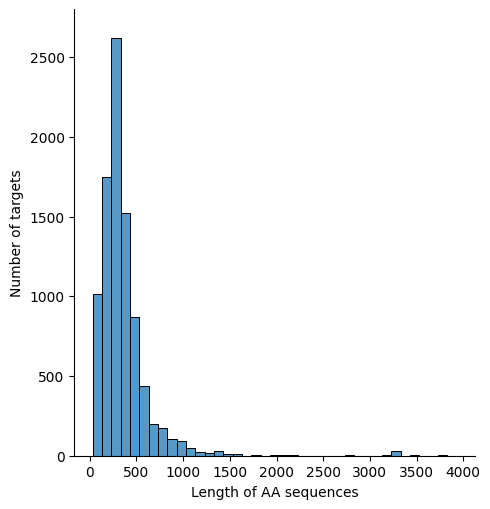

In [3]:
data_length_plot(str2length(pdbbind_df["Target"]), "PDBbindTarget", 100, "Length of AA sequences", "Number of targets", 2800)

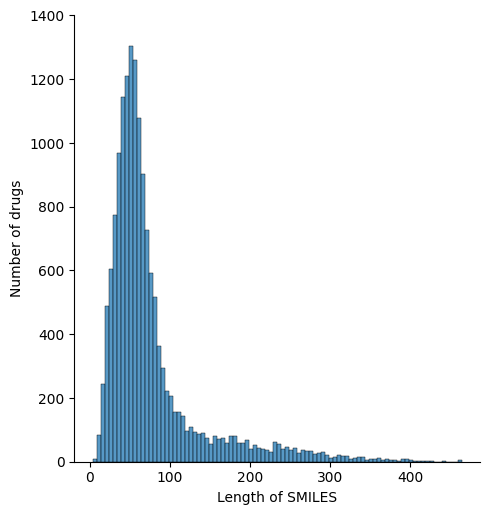

In [4]:
data_length_plot(str2length(pdbbind_df["Drug"]), "PDBbindDrug", 5, "Length of SMILES", "Number of drugs", 1400)

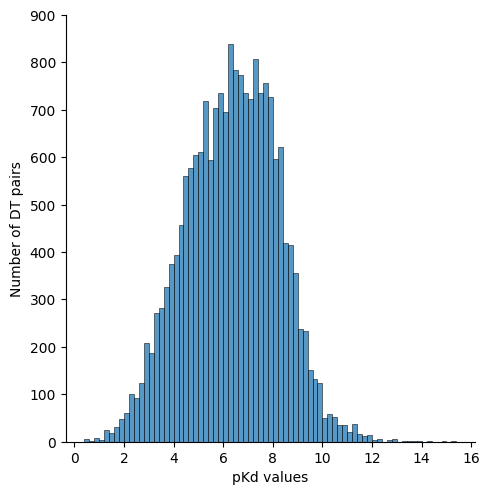

In [5]:
data_length_plot(pdbbind_df["Y"], "PDBbindAffinity", 0.2, "pKd values", "Number of DT pairs", 900)

## 4 dataset split

In [1]:
import pandas as pd
import numpy as np
pdbbind_df = pd.read_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv')

In [2]:
pdbbind_df

PDB_ID                                               Drug  \
0       3ZZF                      CC(=O)N[C@@H](CCC(=O)O)C(=O)O   
1       3GWW        C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1   
2       1W8L                             CC(=O)N1CCC[C@@H](C)C1   
3       3FQA                                  Nc1cccc(C(=O)O)c1   
4       1ZSB                         CC(=O)Nc1nnc(S(N)(=O)=O)s1   
...      ...                                                ...   
19342   7CPA  CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...   
19343   2XUF  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...   
19344   1AVD          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   
19345   2XUI  Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...   
19346   2AVI          O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21   

                                                  Target      Y  Drug_Index  \
0      MGHHHHHHVSSTNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVS...   0.40           0   
1      MEVKREHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIP...   0.45           1   
2      MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...   0.49           2   
3      FKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYA...   0.49           3   
4      SHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPL...   0.60           4   
...                                                  ...    ...         ...   
19342  ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...  13.96       19342   
19343  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...  14.39       19343   
19344  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...  15.00       19344   
19345  EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...  15.00       19345   
19346  ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKE...  15.22       19346   

       Protein_Index  
0               4129  
1               1057  
2               7514  
3               1903  
4               5316  
...              ...  
19342           4075  
19343            755  
19344           8114  
19345            754  
19346           8114  

[19347 rows x 6 columns]

In [3]:
# we use the time-split defined in EquiBind paper.
# https://github.com/HannesStark/EquiBind/tree/main/data
valid = np.loadtxt('../../../data/dta-datasets/PDBbind/timesplit_no_lig_overlap_val.txt', dtype=str)
valid_pdb = valid.tolist()
valid_pdb

['4lp9',
 '1me7',
 '2zv9',
 '2qo8',
 '1cw2',
 '3k5c',
 '2o65',
 '4kqq',
 '3rdv',
 '1d4w',
 '1q4l',
 '4b5w',
 '4bgg',
 '4mm5',
 '3iej',
 '3ftu',
 '830c',
 '2xye',
 '1olu',
 '2wk2',
 '4pxf',
 '5o0j',
 '1my2',
 '5czm',
 '4jit',
 '5mb1',
 '1sqp',
 '3zlw',
 '4xqu',
 '3hkq',
 '6fns',
 '5e0l',
 '2p8o',
 '4gzw',
 '3n87',
 '1lhc',
 '4itj',
 '4m7c',
 '4olh',
 '4q1e',
 '5l7e',
 '3faa',
 '5vqx',
 '3pka',
 '5x54',
 '5a9u',
 '4n9e',
 '4est',
 '1il9',
 '4igr',
 '3t2t',
 '6dar',
 '3gol',
 '3vbg',
 '2ydk',
 '4zpf',
 '5zo7',
 '4xnw',
 '1fpy',
 '2r1y',
 '6m8w',
 '2jds',
 '5icx',
 '1hwr',
 '6bj2',
 '4b4m',
 '1zsb',
 '4do3',
 '3t3i',
 '1f8a',
 '2ke1',
 '5ezx',
 '3p78',
 '4rvm',
 '3ovn',
 '5wzv',
 '4udb',
 '1okz',
 '1mpl',
 '5npc',
 '5ff6',
 '1hlf',
 '1nvq',
 '4bhf',
 '4y4g',
 '5mkz',
 '2o0u',
 '3bcs',
 '1wvc',
 '4fsl',
 '3oz1',
 '6dgt',
 '1me8',
 '2puy',
 '4odp',
 '1hpx',
 '4nrq',
 '1z2b',
 '3uik',
 '3mfv',
 '3vqh',
 '4w9g',
 '4xek',
 '4jok',
 '2wap',
 '1g50',
 '4j0p',
 '2o9a',
 '3m94',
 '4i1c',
 '5a82',
 

In [4]:
len(valid_pdb)

968

In [5]:
test = np.loadtxt('../../../data/dta-datasets/PDBbind/timesplit_test.txt', dtype=str)
test_pdb = test.tolist()
test_pdb

['6qqw',
 '6d08',
 '6jap',
 '6np2',
 '6uvp',
 '6oxq',
 '6jsn',
 '6hzb',
 '6qrc',
 '6oio',
 '6jag',
 '6moa',
 '6hld',
 '6i9a',
 '6e4c',
 '6g24',
 '6jb4',
 '6s55',
 '6seo',
 '6dyz',
 '5zk5',
 '6jid',
 '5ze6',
 '6qlu',
 '6a6k',
 '6qgf',
 '6e3z',
 '6te6',
 '6pka',
 '6g2o',
 '6jsf',
 '5zxk',
 '6qxd',
 '6n97',
 '6jt3',
 '6qtr',
 '6oy1',
 '6n96',
 '6qzh',
 '6qqz',
 '6qmt',
 '6ibx',
 '6hmt',
 '5zk7',
 '6k3l',
 '6cjs',
 '6n9l',
 '6ibz',
 '6ott',
 '6gge',
 '6hot',
 '6e3p',
 '6md6',
 '6hlb',
 '6fe5',
 '6uwp',
 '6npp',
 '6g2f',
 '6mo7',
 '6bqd',
 '6nsv',
 '6i76',
 '6n53',
 '6g2c',
 '6eeb',
 '6n0m',
 '6uvy',
 '6ovz',
 '6olx',
 '6v5l',
 '6hhg',
 '5zcu',
 '6dz2',
 '6mjq',
 '6efk',
 '6s9w',
 '6gdy',
 '6kqi',
 '6ueg',
 '6oxt',
 '6oy0',
 '6qr7',
 '6i41',
 '6cyg',
 '6qmr',
 '6g27',
 '6ggb',
 '6g3c',
 '6n4e',
 '6fcj',
 '6quv',
 '6iql',
 '6i74',
 '6qr4',
 '6rnu',
 '6jib',
 '6izq',
 '6qw8',
 '6qto',
 '6qrd',
 '6hza',
 '6e5s',
 '6dz3',
 '6e6w',
 '6cyh',
 '5zlf',
 '6om4',
 '6gga',
 '6pgp',
 '6qqv',
 '6qtq',
 

In [6]:
len(test_pdb)

363

In [7]:
pdbbind_df['PDB_ID'].isin(['3ZZF']).any()

True

In [8]:
valid_index_list = []
for pdb in valid_pdb:
    pdb_id = pdb.upper()
    if pdbbind_df['PDB_ID'].isin([pdb_id]).any():
        pdb_index = pdbbind_df[pdbbind_df['PDB_ID']==pdb_id].index.tolist()[0]
        valid_index_list.append(pdb_index)
    else:
        continue

In [9]:
valid_index_list

[8848,
 12593,
 15777,
 17006,
 8593,
 14819,
 8757,
 1939,
 4428,
 11588,
 13388,
 1084,
 15025,
 14746,
 10608,
 1467,
 18431,
 16711,
 3019,
 11261,
 802,
 4077,
 14795,
 16688,
 10561,
 10426,
 16267,
 1614,
 8328,
 5838,
 2223,
 9626,
 3314,
 4572,
 19090,
 9706,
 8539,
 16605,
 16210,
 10423,
 16117,
 9307,
 9048,
 4748,
 19008,
 15027,
 4793,
 1156,
 12663,
 294,
 10645,
 12188,
 13747,
 16109,
 11005,
 18091,
 14749,
 8004,
 3259,
 8922,
 16268,
 11751,
 16694,
 6084,
 10724,
 4,
 2343,
 4061,
 4656,
 5692,
 12113,
 11735,
 18064,
 365,
 10714,
 18292,
 16523,
 1718,
 2148,
 4804,
 6744,
 16451,
 1234,
 135,
 3859,
 6334,
 5378,
 3139,
 14571,
 17528,
 13339,
 12594,
 3294,
 4068,
 19245,
 1237,
 9563,
 4610,
 353,
 7770,
 5586,
 6844,
 2283,
 10548,
 9071,
 12988,
 1793,
 4965,
 15967,
 6669,
 12533,
 10306,
 16884,
 12215,
 1375,
 6567,
 11182,
 6521,
 8846,
 2761,
 2987,
 17011,
 8079,
 7451,
 17259,
 1758,
 7842,
 323,
 12366,
 2546,
 12735,
 2763,
 129,
 6497,
 15205,
 190

In [10]:
len(valid_index_list) # 6 lose

962

In [11]:
file = open('../../../data/dta-datasets/PDBbind/valid_index.txt', 'w')
file.writelines(str(valid_index_list))
file.close()

In [12]:
test_index_list = []
for pdb in test_pdb:
    pdb_id = pdb.upper()
    if pdbbind_df['PDB_ID'].isin([pdb_id]).any():
        pdb_index = pdbbind_df[pdbbind_df['PDB_ID']==pdb_id].index.tolist()[0]
        test_index_list.append(pdb_index)
    else:
        print(pdb_id)

In [13]:
test_index_list

[3942,
 5670,
 4152,
 11210,
 2164,
 19265,
 16947,
 17969,
 4412,
 10190,
 3256,
 12178,
 18352,
 18981,
 18914,
 495,
 7977,
 8816,
 4006,
 18342,
 16776,
 4988,
 1109,
 3675,
 13690,
 8119,
 14789,
 10305,
 7821,
 11108,
 17041,
 6324,
 8164,
 5247,
 16656,
 3677,
 19051,
 6149,
 17225,
 11027,
 11666,
 17603,
 12039,
 10875,
 12771,
 18808,
 10855,
 14409,
 6150,
 7291,
 3009,
 17599,
 5075,
 19058,
 18474,
 14031,
 8273,
 5293,
 4833,
 9539,
 14969,
 4954,
 15176,
 3729,
 5749,
 7476,
 8120,
 1861,
 5988,
 1523,
 14791,
 6879,
 17829,
 15182,
 11204,
 12794,
 6249,
 15852,
 3906,
 18920,
 18481,
 12483,
 2580,
 2495,
 15394,
 842,
 6020,
 11582,
 15690,
 12477,
 720,
 18526,
 6281,
 8950,
 2163,
 7383,
 6383,
 9654,
 3676,
 11947,
 18477,
 9798,
 17883,
 18926,
 864,
 1268,
 6217,
 4320,
 11945,
 4494,
 1671,
 3875,
 5928,
 13477,
 4597,
 15529,
 7469,
 18989,
 15074,
 2509,
 12853,
 4410,
 18576,
 11110,
 11028,
 16723,
 4004,
 18708,
 16980,
 8949,
 6021,
 6929,
 18685,
 19216,


In [14]:
len(test_index_list)  # 0 loss

363

In [15]:
file = open('../../../data/dta-datasets/PDBbind/test_index.txt', 'w')
file.writelines(str(test_index_list))
file.close()

In [16]:
test_index_list.extend(valid_index_list)

In [17]:
len(test_index_list)

1325

In [18]:
test_index_list

[3942,
 5670,
 4152,
 11210,
 2164,
 19265,
 16947,
 17969,
 4412,
 10190,
 3256,
 12178,
 18352,
 18981,
 18914,
 495,
 7977,
 8816,
 4006,
 18342,
 16776,
 4988,
 1109,
 3675,
 13690,
 8119,
 14789,
 10305,
 7821,
 11108,
 17041,
 6324,
 8164,
 5247,
 16656,
 3677,
 19051,
 6149,
 17225,
 11027,
 11666,
 17603,
 12039,
 10875,
 12771,
 18808,
 10855,
 14409,
 6150,
 7291,
 3009,
 17599,
 5075,
 19058,
 18474,
 14031,
 8273,
 5293,
 4833,
 9539,
 14969,
 4954,
 15176,
 3729,
 5749,
 7476,
 8120,
 1861,
 5988,
 1523,
 14791,
 6879,
 17829,
 15182,
 11204,
 12794,
 6249,
 15852,
 3906,
 18920,
 18481,
 12483,
 2580,
 2495,
 15394,
 842,
 6020,
 11582,
 15690,
 12477,
 720,
 18526,
 6281,
 8950,
 2163,
 7383,
 6383,
 9654,
 3676,
 11947,
 18477,
 9798,
 17883,
 18926,
 864,
 1268,
 6217,
 4320,
 11945,
 4494,
 1671,
 3875,
 5928,
 13477,
 4597,
 15529,
 7469,
 18989,
 15074,
 2509,
 12853,
 4410,
 18576,
 11110,
 11028,
 16723,
 4004,
 18708,
 16980,
 8949,
 6021,
 6929,
 18685,
 19216,


In [19]:
train_index_list = []
for index in range(pdbbind_df.shape[0]):
    if index not in test_index_list:
        train_index_list.append(index)

In [20]:
train_index_list

[0,
 1,
 2,
 3,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,


In [21]:
len(train_index_list)

18022

In [22]:
file = open('../../../data/dta-datasets/PDBbind/train_index.txt', 'w')
file.writelines(str(train_index_list))
file.close()

## 5 GearNet construction

In [1]:
import pickle
from tqdm import tqdm
from torchdrug import utils, transforms, data, models, layers

In [2]:
protein_pkl = '../../../data/dta-datasets/PDBbind/pocket_Protein.pkl'
with utils.smart_open(protein_pkl, "rb") as fin:
    protein_list = pickle.load(fin)

In [3]:
protein_list

[Protein(num_atom=390, num_bond=790, num_residue=39),
 Protein(num_atom=222, num_bond=428, num_residue=22),
 Protein(num_atom=350, num_bond=618, num_residue=62),
 Protein(num_atom=492, num_bond=962, num_residue=51),
 Protein(num_atom=723, num_bond=1408, num_residue=80),
 Protein(num_atom=459, num_bond=906, num_residue=46),
 Protein(num_atom=705, num_bond=1380, num_residue=76),
 Protein(num_atom=321, num_bond=586, num_residue=55),
 Protein(num_atom=275, num_bond=552, num_residue=27),
 Protein(num_atom=527, num_bond=1040, num_residue=53),
 Protein(num_atom=441, num_bond=862, num_residue=44),
 Protein(num_atom=396, num_bond=790, num_residue=43),
 Protein(num_atom=384, num_bond=768, num_residue=41),
 Protein(num_atom=552, num_bond=1084, num_residue=58),
 Protein(num_atom=539, num_bond=1056, num_residue=56),
 Protein(num_atom=152, num_bond=298, num_residue=16),
 Protein(num_atom=475, num_bond=930, num_residue=54),
 Protein(num_atom=454, num_bond=894, num_residue=46),
 Protein(num_atom=454, 

In [4]:
len(protein_list)

9018

In [5]:
graph_construction_model = layers.GraphConstruction(node_layers=[layers.geometry.AlphaCarbonNode()], 
                                                    edge_layers=[layers.geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 layers.geometry.KNNEdge(k=10, min_distance=5),
                                                                 layers.geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

In [6]:
output_list = []
i = -1
for protein in protein_list:
    i = i + 1
    # print(protein)
    graph = data.Protein.pack([protein])
    try:
        transGraph = graph_construction_model(graph)
        output_list.append(transGraph)
    except:
        print(i)

In [7]:
len(output_list)

9018

In [8]:
output_list

[PackedProtein(batch_size=1, num_atoms=[39], num_bonds=[501], num_residues=[39]),
 PackedProtein(batch_size=1, num_atoms=[22], num_bonds=[246], num_residues=[22]),
 PackedProtein(batch_size=1, num_atoms=[29], num_bonds=[347], num_residues=[29]),
 PackedProtein(batch_size=1, num_atoms=[50], num_bonds=[713], num_residues=[50]),
 PackedProtein(batch_size=1, num_atoms=[73], num_bonds=[1106], num_residues=[73]),
 PackedProtein(batch_size=1, num_atoms=[46], num_bonds=[588], num_residues=[46]),
 PackedProtein(batch_size=1, num_atoms=[73], num_bonds=[1131], num_residues=[73]),
 PackedProtein(batch_size=1, num_atoms=[34], num_bonds=[552], num_residues=[34]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[340], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[53], num_bonds=[834], num_residues=[53]),
 PackedProtein(batch_size=1, num_atoms=[44], num_bonds=[653], num_residues=[44]),
 PackedProtein(batch_size=1, num_atoms=[43], num_bonds=[632], num_residues=[43]),
 PackedProtein

In [9]:
protein_view = transforms.ProteinView(view="residue", keys="graph1")

In [10]:
transform_list = []
for protein in output_list:
    item = {"graph1": protein}
    transform_list.append(protein_view(item)['graph1'])

In [11]:
transform_list

[PackedProtein(batch_size=1, num_atoms=[39], num_bonds=[501], num_residues=[39]),
 PackedProtein(batch_size=1, num_atoms=[22], num_bonds=[246], num_residues=[22]),
 PackedProtein(batch_size=1, num_atoms=[29], num_bonds=[347], num_residues=[29]),
 PackedProtein(batch_size=1, num_atoms=[50], num_bonds=[713], num_residues=[50]),
 PackedProtein(batch_size=1, num_atoms=[73], num_bonds=[1106], num_residues=[73]),
 PackedProtein(batch_size=1, num_atoms=[46], num_bonds=[588], num_residues=[46]),
 PackedProtein(batch_size=1, num_atoms=[73], num_bonds=[1131], num_residues=[73]),
 PackedProtein(batch_size=1, num_atoms=[34], num_bonds=[552], num_residues=[34]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[340], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[53], num_bonds=[834], num_residues=[53]),
 PackedProtein(batch_size=1, num_atoms=[44], num_bonds=[653], num_residues=[44]),
 PackedProtein(batch_size=1, num_atoms=[43], num_bonds=[632], num_residues=[43]),
 PackedProtein

In [13]:
transform_list[0].node_position

tensor([[167.9990, 139.3250,  84.0660],
        [173.6170, 135.6730,  85.2830],
        [179.3310, 139.4630,  79.0740],
        [179.1230, 138.9820,  82.7560],
        [182.0580, 140.0870,  84.8680],
        [182.7340, 138.7790,  88.3810],
        [179.7670, 136.4590,  88.9490],
        [181.1430, 134.4160,  91.6940],
        [179.4300, 137.5660,  92.9450],
        [175.9650, 138.7030,  91.9370],
        [174.8580, 141.0390,  89.1520],
        [176.6060, 144.3060,  88.4330],
        [173.0630, 145.0180,  87.0640],
        [173.6260, 147.9200,  84.6550],
        [177.8060, 160.6520,  94.5870],
        [191.9270, 150.5590,  98.7740],
        [188.8850, 148.3580,  98.0100],
        [185.6500, 150.0660,  99.0660],
        [183.6510, 147.5430, 101.0710],
        [177.8360, 156.5590,  99.8430],
        [176.6020, 154.6930,  96.8220],
        [178.9160, 153.0720,  94.3090],
        [175.8790, 152.5300,  92.1300],
        [175.1630, 156.2160,  92.3640],
        [178.7620, 157.0750,  91.5470],


In [15]:
import pickle
from torchdrug import utils
protein_pkl = '../../../data/dta-datasets/PDBbind/gearnet_pocket_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(transform_list, fout)
# ============================== PKL Completing! ============================== #

***

error list
- 2337
- 2923
- 3447
- 8853

error protein test

In [8]:
pocket = protein_list[8853]
pocket

Protein(num_atom=328, num_bond=604, num_residue=54)

In [9]:
graph = data.Protein.pack([pocket])
graph

PackedProtein(batch_size=1, num_atoms=[328], num_bonds=[604], num_residues=[54])

In [10]:
transGraph = graph_construction_model(graph)
transGraph

AssertionError: 

In [16]:
transGraph.unpack()

[Protein(num_atom=33, num_bond=515, num_residue=33)]

***

## Demo test

In [1]:
from torchdrug import datasets

In [2]:
dataset = datasets.PDBBind("../../../data/dta-datasets/PDBbind/", protein_method='gearnet_pocket', drug_method='3d')

==================== Using 3d drug method and gearnet_pocket protein method! ====================


Constructing Dataset from pkl file: 100%|██████████| 19347/19347 [00:00<00:00, 331762.84it/s]


In [3]:
dataset

PDBBind(
  #sample: 19347
  #task: 1
)

In [4]:
dataset.data

[[PackedProtein(batch_size=1, num_atoms=[49], num_bonds=[834], num_residues=[49]),
  Molecule(num_atom=13, num_bond=24)],
 [PackedProtein(batch_size=1, num_atoms=[53], num_bonds=[771], num_residues=[53]),
  Molecule(num_atom=22, num_bond=46)],
 [PackedProtein(batch_size=1, num_atoms=[31], num_bonds=[517], num_residues=[31]),
  Molecule(num_atom=10, num_bond=20)],
 [PackedProtein(batch_size=1, num_atoms=[43], num_bonds=[779], num_residues=[43]),
  Molecule(num_atom=10, num_bond=20)],
 [PackedProtein(batch_size=1, num_atoms=[48], num_bonds=[867], num_residues=[48]),
  Molecule(num_atom=13, num_bond=26)],
 [PackedProtein(batch_size=1, num_atoms=[23], num_bonds=[358], num_residues=[23]),
  Molecule(num_atom=12, num_bond=24)],
 [PackedProtein(batch_size=1, num_atoms=[40], num_bonds=[573], num_residues=[40]),
  Molecule(num_atom=17, num_bond=36)],
 [PackedProtein(batch_size=1, num_atoms=[47], num_bonds=[873], num_residues=[47]),
  Molecule(num_atom=9, num_bond=16)],
 [PackedProtein(batch_siz

In [5]:
dataset.data[0][0].residue_feature.shape

torch.Size([49, 21])

In [6]:
dataset.data[0][1].node_feature.shape

torch.Size([13, 67])

In [7]:
dataset.data[0][0].num_relation

tensor(7)

In [8]:
dataset.data[0][0].edge_list.tolist()

[[46, 41, 1],
 [43, 38, 1],
 [34, 39, 1],
 [33, 39, 1],
 [27, 39, 1],
 [25, 39, 1],
 [31, 39, 1],
 [34, 40, 1],
 [35, 40, 1],
 [33, 40, 1],
 [25, 40, 1],
 [27, 40, 1],
 [35, 41, 1],
 [34, 41, 1],
 [30, 38, 1],
 [37, 42, 1],
 [22, 42, 1],
 [8, 42, 1],
 [23, 42, 1],
 [37, 43, 1],
 [8, 43, 1],
 [7, 43, 1],
 [6, 43, 1],
 [0, 44, 1],
 [8, 44, 1],
 [37, 44, 1],
 [2, 44, 1],
 [30, 36, 1],
 [40, 34, 1],
 [39, 34, 1],
 [41, 34, 1],
 [25, 34, 1],
 [24, 34, 1],
 [23, 34, 1],
 [41, 35, 1],
 [40, 35, 1],
 [42, 35, 1],
 [46, 35, 1],
 [7, 36, 1],
 [6, 36, 1],
 [37, 45, 1],
 [8, 36, 1],
 [43, 36, 1],
 [9, 36, 1],
 [46, 36, 1],
 [41, 36, 1],
 [43, 37, 1],
 [46, 37, 1],
 [42, 37, 1],
 [8, 37, 1],
 [6, 37, 1],
 [7, 37, 1],
 [46, 38, 1],
 [20, 18, 2],
 [8, 6, 2],
 [9, 7, 2],
 [10, 8, 2],
 [11, 9, 2],
 [12, 10, 2],
 [13, 11, 2],
 [14, 12, 2],
 [15, 13, 2],
 [16, 14, 2],
 [17, 15, 2],
 [18, 16, 2],
 [19, 17, 2],
 [7, 5, 2],
 [21, 19, 2],
 [22, 20, 2],
 [23, 21, 2],
 [24, 22, 2],
 [25, 23, 2],
 [26, 24, 2],


In [9]:
dataset.smiles

['CC(=O)N[C@@H](CCC(=O)O)C(=O)O',
 'C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1',
 'CC(=O)N1CCC[C@@H](C)C1',
 'Nc1cccc(C(=O)O)c1',
 'CC(=O)Nc1nnc(S(N)(=O)=O)s1',
 'CO[C@@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O',
 '[NH3+][C@](CF)(Cc1c[nH]c2ccccc12)C(=O)[O-]',
 'CSCC[C@H]([NH3+])C(=O)O',
 'O=P(O)(O)OC[C@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
 'O=C(O)CC(O)(CC(=O)O)C(=O)O',
 'OCC(O)CO',
 'C[NH2+]CCCC[C@H]([NH3+])C(=O)O',
 'OC[C@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O',
 'OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O',
 'O=C(O)COP(=O)(O)O',
 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O',
 'COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC',
 '[NH3+][C@@H](Cc1c[nH]c2ccccc12)C(=O)[O-]',
 'O=C(O)CCC(=O)O',
 'O=C(O)CC(O)(CC(=O)O)C(=O)O',
 '[H]/N=C(\\N)NC[C@H]([NH3+])C(=O)O',
 '[H]/N=C(\\N)NC[C@H]([NH3+])C(=O)O',
 'Nc1ncnc2c1ncn2[C@@H]1O[C@@H]2CO[P@@](=O)(O)O[C@H]2[C@H]1O',
 'O=C1O[C@H]([C@H](O)

In [10]:
dataset.targets

{'affinity': [0.4,
  0.45,
  0.49,
  0.49,
  0.6,
  0.66,
  0.75,
  0.82,
  0.82,
  0.82,
  0.96,
  1.0,
  1.0,
  1.0,
  1.05,
  1.1,
  1.11,
  1.11,
  1.24,
  1.24,
  1.26,
  1.26,
  1.27,
  1.28,
  1.3,
  1.3,
  1.3,
  1.3,
  1.31,
  1.31,
  1.31,
  1.31,
  1.35,
  1.35,
  1.36,
  1.36,
  1.4,
  1.4,
  1.4,
  1.4,
  1.4,
  1.4,
  1.43,
  1.44,
  1.44,
  1.45,
  1.49,
  1.49,
  1.49,
  1.52,
  1.52,
  1.52,
  1.54,
  1.55,
  1.57,
  1.57,
  1.58,
  1.58,
  1.59,
  1.6,
  1.6,
  1.62,
  1.62,
  1.64,
  1.64,
  1.66,
  1.68,
  1.68,
  1.7,
  1.7,
  1.7,
  1.7,
  1.7,
  1.7,
  1.71,
  1.72,
  1.72,
  1.72,
  1.72,
  1.72,
  1.74,
  1.74,
  1.74,
  1.75,
  1.75,
  1.77,
  1.78,
  1.78,
  1.79,
  1.8,
  1.8,
  1.82,
  1.82,
  1.82,
  1.82,
  1.82,
  1.82,
  1.85,
  1.85,
  1.88,
  1.88,
  1.88,
  1.89,
  1.9,
  1.9,
  1.91,
  1.92,
  1.92,
  1.92,
  1.94,
  1.94,
  1.95,
  1.95,
  1.96,
  1.96,
  1.96,
  1.98,
  1.98,
  1.98,
  1.99,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,


In [11]:
len(dataset.targets['affinity'])

19347

In [12]:
train_set, valid_set, test_set = dataset.deepdta_split()

In [13]:
train_set

In [14]:
train_set.indices

[0,
 1,
 2,
 3,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,
